In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports and Plot Settings

In [16]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from spins import linear_eom, lmg_eom
from initial_samplings import discrete_spin_sampling, continious_spin_sampling
from ode_solver import solve_twa_dynamics

In [17]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to mtch 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11
}

plt.style.use('seaborn-v0_8-white')
plt.rcParams.update(tex_fonts)

# Closed System Test

## Linear

In [18]:
n_trajectories = 10_000
omega = 1.0 
t_max = 10.0
n_stps = 10_000
t_eval = jnp.linspace(0, t_max, n_stps)

# Sample Initial Conditions
key = jax.random.PRNGKey(42)
s0_batch = discrete_spin_sampling(key, n_trajectories, initial_z=-1.0)

In [19]:
trajectories = solve_twa_dynamics(
    state_initial = s0_batch,
    t_array = t_eval,
    eom_func = linear_eom,
    system_args = omega
)

In [20]:
sigma_z_mean = jnp.mean(trajectories[:, :, 2], axis=1)
sigma_z_var = jnp.var(trajectories[:, :, 2], axis=1)

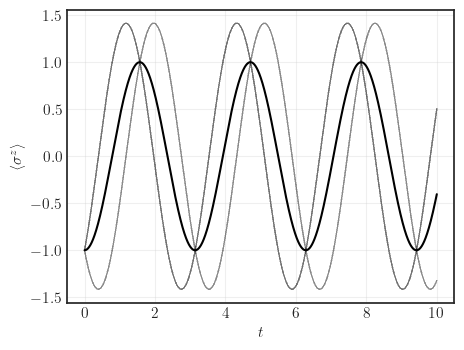

In [21]:
fig, ax = plt.subplots(figsize=(5, 3.8))
plt.plot(t_eval, trajectories[:, :100, 2], color='k', linewidth = 1, alpha = 0.01)
plt.plot(t_eval, sigma_z_mean, color = 'k')
plt.ylabel(r'$\langle \sigma^z\rangle$')
plt.xlabel(r'$t$')
plt.grid(alpha = 0.3)
plt.show()

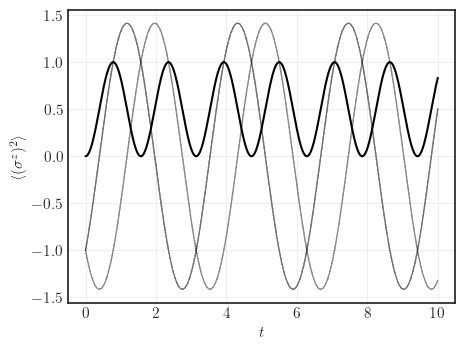

In [22]:
fig, ax = plt.subplots(figsize=(5, 3.8))
plt.plot(t_eval, trajectories[:, :100, 2], color='k', linewidth = 1, alpha = 0.01)
plt.plot(t_eval, sigma_z_var, color = 'k')
plt.ylabel(r'$\langle (\sigma^z)^2\rangle$')
plt.xlabel(r'$t$')
plt.grid(alpha = 0.3)
plt.show()

## No Linear

In [28]:
n_trajectories = 10_000
omega = 1.0 
chi = 0.5
t_max = 15.0
n_stps = 10_000
t_eval = jnp.linspace(0, t_max, n_stps)

args = (omega, chi)

# Sample Initial Conditions
key = jax.random.PRNGKey(42)
s0_batch = discrete_spin_sampling(key, n_trajectories, initial_z=-1.0)

In [29]:
trajectories = solve_twa_dynamics(
    state_initial = s0_batch,
    t_array = t_eval,
    eom_func = lmg_eom,
    system_args = args
)

In [30]:
sigma_z_mean = jnp.mean(trajectories[:, :, 2], axis=1)
sigma_z_var = jnp.var(trajectories[:, :, 2], axis=1)

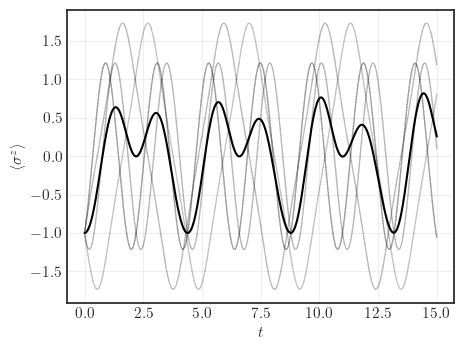

In [31]:
fig, ax = plt.subplots(figsize=(5, 3.8))
plt.plot(t_eval, trajectories[:, :100, 2], color='k', linewidth = 1, alpha = 0.01)
plt.plot(t_eval, sigma_z_mean, color = 'k')
plt.ylabel(r'$\langle \sigma^z\rangle$')
plt.xlabel(r'$t$')
plt.grid(alpha = 0.3)
plt.show()

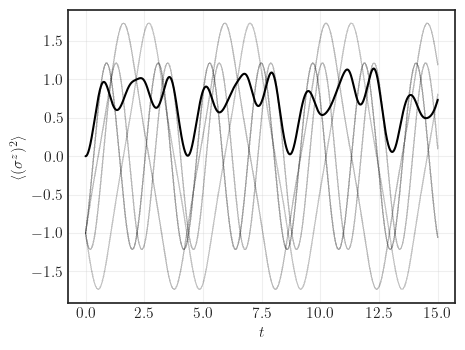

In [33]:
fig, ax = plt.subplots(figsize=(5, 3.8))
plt.plot(t_eval, trajectories[:, :100, 2], color='k', linewidth = 1, alpha = 0.01)
plt.plot(t_eval, sigma_z_var, color = 'k')
plt.ylabel(r'$\langle (\sigma^z)^2\rangle$')
plt.xlabel(r'$t$')
plt.grid(alpha = 0.3)
plt.show()